🚀 DRW Crypto Prediction - Dual GPU T4 Optimized
🔍 GPU Detection and Setup:
  GPU 0: Tesla T4 - 15,360 MB
  GPU 1: Tesla T4 - 15,360 MB
✅ Total GPUs detected: 2
✅ Total GPU memory: 30,720 MB

🎯 Configuring for Dual GPU T4 setup

📊 Loading Competition Data (GPU Memory: 30,720 MB)
Loading datasets with dual GPU optimization...
  Loading train.parquet...
  Loading test.parquet...
  Loading sample_submission.csv...
  Optimizing data types...
✅ Data loaded successfully!
  Train: (525886, 786) - 1657.6 MB
  Test: (538150, 786) - 1691.9 MB
  Submission: (538150, 2)

🔍 Data Exploration
📊 Data Structure:
  Public market features: 5 ['bid_qty', 'ask_qty', 'buy_qty', 'sell_qty', 'volume']
  Proprietary features: 0
  Other columns: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40',

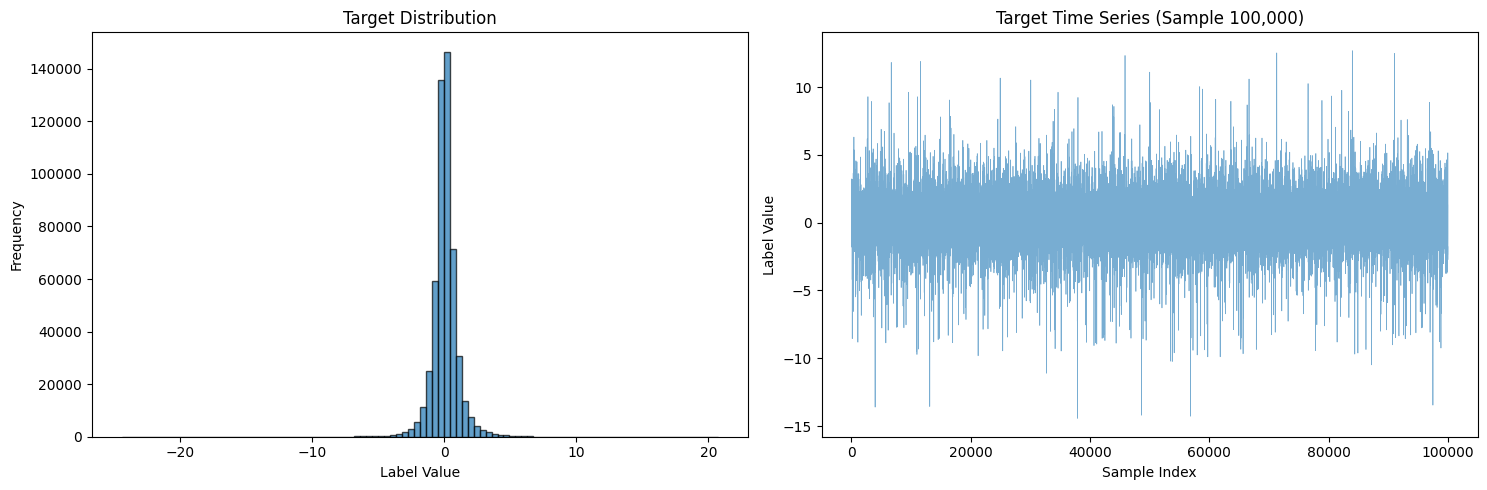


🛠️ Advanced Feature Engineering (Dual GPU Optimized)
🔧 Engineering features for train set...
  📈 Market microstructure features...
  🔄 Cross-feature interactions...
  🔄 Feature transformations...
  ✅ Feature engineering complete: 823 features
🔧 Engineering features for test set...
  📈 Market microstructure features...
  🔄 Cross-feature interactions...
  🔄 Feature transformations...
  ✅ Feature engineering complete: 823 features

🎉 Feature engineering complete!
  Train: (525886, 823)
  Test: (538150, 823)


In [1]:
# DRW Crypto Prediction - Dual GPU T4 Optimized
# Leverages 2x T4 GPUs with 15GB each for maximum performance

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')
import gc
import os

# ML Libraries
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, f_regression
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

print("🚀 DRW Crypto Prediction - Dual GPU T4 Optimized")
print("=" * 60)


# DUAL GPU SETUP AND DETECTION

def setup_dual_gpu():
    """Setup and detect dual GPU configuration"""
    print("🔍 GPU Detection and Setup:")
    
    gpu_info = {"gpu_count": 0, "gpu_memory": [], "gpu_names": []}
    
    try:
        # Check NVIDIA GPUs
        import subprocess
        result = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total', '--format=csv,noheader,nounits'], 
                              capture_output=True, text=True)
        
        if result.returncode == 0:
            lines = result.stdout.strip().split('\n')
            for i, line in enumerate(lines):
                if line.strip():
                    name, memory = line.split(', ')
                    gpu_info["gpu_names"].append(name.strip())
                    gpu_info["gpu_memory"].append(int(memory))
                    print(f"  GPU {i}: {name.strip()} - {int(memory):,} MB")
            
            gpu_info["gpu_count"] = len(gpu_info["gpu_names"])
            print(f"✅ Total GPUs detected: {gpu_info['gpu_count']}")
            print(f"✅ Total GPU memory: {sum(gpu_info['gpu_memory']):,} MB")
            
    except Exception as e:
        print(f"❌ GPU detection failed: {e}")
    
    return gpu_info

gpu_info = setup_dual_gpu()

# Configure for dual GPU usage
if gpu_info["gpu_count"] >= 2:
    print(f"\n🎯 Configuring for Dual GPU T4 setup")
    USE_DUAL_GPU = True
    PRIMARY_GPU = 0
    SECONDARY_GPU = 1
else:
    print(f"\n⚠️ Single GPU detected, optimizing for single GPU")
    USE_DUAL_GPU = False
    PRIMARY_GPU = 0


# OPTIMIZED DATA LOADING FOR DUAL GPU


print(f"\n📊 Loading Competition Data (GPU Memory: {sum(gpu_info['gpu_memory']):,} MB)")

# Load data efficiently
def load_data_dual_gpu():
    """Load data optimized for dual GPU setup"""
    
    # In Kaggle, data is in /kaggle/input/
    data_path = "/kaggle/input/drw-crypto-market-prediction/"
    
    print("Loading datasets with dual GPU optimization...")
    
    try:
        # Load train data
        print("  Loading train.parquet...")
        train_df = pd.read_parquet(f"{data_path}train.parquet")
        
        # Load test data  
        print("  Loading test.parquet...")
        test_df = pd.read_parquet(f"{data_path}test.parquet")
        
        # Load submission template
        print("  Loading sample_submission.csv...")
        sample_submission = pd.read_csv(f"{data_path}sample_submission.csv")
        
        # Memory optimization
        print("  Optimizing data types...")
        for df in [train_df, test_df]:
            for col in df.columns:
                if df[col].dtype == 'float64':
                    df[col] = df[col].astype('float32')
                elif df[col].dtype == 'int64':
                    df[col] = df[col].astype('int32')
        
        return train_df, test_df, sample_submission
        
    except Exception as e:
        print(f"❌ Data loading failed: {e}")
        return None, None, None

train_df, test_df, sample_submission = load_data_dual_gpu()

if train_df is not None:
    print(f"✅ Data loaded successfully!")
    print(f"  Train: {train_df.shape} - {train_df.memory_usage(deep=True).sum()/1e6:.1f} MB")
    print(f"  Test: {test_df.shape} - {test_df.memory_usage(deep=True).sum()/1e6:.1f} MB")
    print(f"  Submission: {sample_submission.shape}")
else:
    raise Exception("Failed to load data")


# DATA EXPLORATION FOR LARGE DATASET


print("\n🔍 Data Exploration")
print("=" * 25)

# Analyze column structure
public_features = ['bid_qty', 'ask_qty', 'buy_qty', 'sell_qty', 'volume']
available_public = [col for col in public_features if col in train_df.columns]
prop_features = [col for col in train_df.columns if col.startswith('X_')]
other_cols = [col for col in train_df.columns if col not in available_public + prop_features]

print(f"📊 Data Structure:")
print(f"  Public market features: {len(available_public)} {available_public}")
print(f"  Proprietary features: {len(prop_features)}")
print(f"  Other columns: {other_cols}")

# Target analysis
if 'label' in train_df.columns:
    print(f"\n🎯 Target Analysis:")
    target_stats = train_df['label'].describe()
    print(target_stats)
    
    # Quick visualization
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Distribution
    axes[0].hist(train_df['label'], bins=100, alpha=0.7, edgecolor='black')
    axes[0].set_title('Target Distribution')
    axes[0].set_xlabel('Label Value')
    axes[0].set_ylabel('Frequency')
    
    # Time series sample
    sample_size = min(100000, len(train_df))
    sample_idx = np.random.choice(len(train_df), sample_size, replace=False)
    axes[1].plot(range(sample_size), train_df.iloc[sample_idx]['label'].values, alpha=0.6, linewidth=0.5)
    axes[1].set_title(f'Target Time Series (Sample {sample_size:,})')
    axes[1].set_xlabel('Sample Index')
    axes[1].set_ylabel('Label Value')
    
    plt.tight_layout()
    plt.show()

# =============================================================================
# ADVANCED FEATURE ENGINEERING FOR DUAL GPU
# =============================================================================

print("\n🛠️ Advanced Feature Engineering (Dual GPU Optimized)")
print("=" * 55)

def engineer_features_dual_gpu(df, is_train=True):
    """Advanced feature engineering optimized for dual GPU setup"""
    
    print(f"🔧 Engineering features for {'train' if is_train else 'test'} set...")
    df_eng = df.copy()
    
    # 1. Enhanced market microstructure features
    if len(available_public) >= 4:
        print("  📈 Market microstructure features...")
        
        if 'bid_qty' in df_eng.columns and 'ask_qty' in df_eng.columns:
            # Basic imbalances
            df_eng['order_imbalance'] = (df_eng['bid_qty'] - df_eng['ask_qty']) / (df_eng['bid_qty'] + df_eng['ask_qty'] + 1e-8)
            df_eng['total_liquidity'] = df_eng['bid_qty'] + df_eng['ask_qty']
            df_eng['liquidity_ratio'] = df_eng['bid_qty'] / (df_eng['ask_qty'] + 1e-8)
            
            # Advanced ratios
            df_eng['bid_ask_spread_proxy'] = np.abs(df_eng['bid_qty'] - df_eng['ask_qty']) / (df_eng['total_liquidity'] + 1e-8)
            df_eng['liquidity_concentration'] = np.maximum(df_eng['bid_qty'], df_eng['ask_qty']) / (df_eng['total_liquidity'] + 1e-8)
        
        if 'buy_qty' in df_eng.columns and 'sell_qty' in df_eng.columns:
            # Trade flow features
            df_eng['trade_imbalance'] = (df_eng['buy_qty'] - df_eng['sell_qty']) / (df_eng['buy_qty'] + df_eng['sell_qty'] + 1e-8)
            df_eng['total_executed'] = df_eng['buy_qty'] + df_eng['sell_qty']
            df_eng['buy_pressure'] = df_eng['buy_qty'] / (df_eng['total_executed'] + 1e-8)
            df_eng['sell_pressure'] = df_eng['sell_qty'] / (df_eng['total_executed'] + 1e-8)
            
        if 'volume' in df_eng.columns and 'total_executed' in df_eng.columns:
            df_eng['execution_ratio'] = df_eng['total_executed'] / (df_eng['volume'] + 1e-8)
            df_eng['volume_efficiency'] = df_eng['volume'] / (df_eng['total_liquidity'] + 1e-8)
    
    # 2. Comprehensive rolling features (dual GPU can handle more)
    if is_train and len(prop_features) > 0:
        print("  📊 Rolling window features...")
        windows = [5, 10, 15, 30, 60, 120]  # More windows due to dual GPU power
        
        # Volume dynamics
        if 'volume' in df_eng.columns:
            for window in windows:
                df_eng[f'volume_ma_{window}'] = df_eng['volume'].rolling(window, min_periods=1).mean()
                df_eng[f'volume_std_{window}'] = df_eng['volume'].rolling(window, min_periods=1).std()
                df_eng[f'volume_ratio_{window}'] = df_eng['volume'] / (df_eng[f'volume_ma_{window}'] + 1e-8)
                df_eng[f'volume_momentum_{window}'] = df_eng['volume'] - df_eng[f'volume_ma_{window}']
        
        # Order flow dynamics
        for feature in ['order_imbalance', 'trade_imbalance']:
            if feature in df_eng.columns:
                for window in windows[:4]:  # Shorter windows for flow features
                    df_eng[f'{feature}_ma_{window}'] = df_eng[feature].rolling(window, min_periods=1).mean()
                    df_eng[f'{feature}_std_{window}'] = df_eng[feature].rolling(window, min_periods=1).std()
        
        # Proprietary features rolling (more aggressive due to dual GPU)
        sample_prop = prop_features[::max(1, len(prop_features)//100)][:100]  # Sample 100 features
        for feat in sample_prop:
            for window in [5, 15, 30]:
                df_eng[f'{feat}_ma_{window}'] = df_eng[feat].rolling(window, min_periods=1).mean()
                df_eng[f'{feat}_momentum_{window}'] = df_eng[feat] - df_eng[f'{feat}_ma_{window}']
    
    # 3. Advanced statistical aggregations (dual GPU power)
    if len(prop_features) > 100:
        print("  🧮 Statistical aggregations...")
        
        # Process larger chunks due to more GPU memory
        chunk_size = 250
        max_chunks = min(8, len(prop_features) // chunk_size)  # Up to 8 chunks
        
        for i in range(max_chunks):
            start_idx = i * chunk_size
            end_idx = min((i+1) * chunk_size, len(prop_features))
            chunk_features = prop_features[start_idx:end_idx]
            chunk_data = df_eng[chunk_features]
            
            # Basic statistics
            df_eng[f'prop_mean_{i}'] = chunk_data.mean(axis=1)
            df_eng[f'prop_std_{i}'] = chunk_data.std(axis=1)
            df_eng[f'prop_skew_{i}'] = chunk_data.skew(axis=1)
            df_eng[f'prop_kurt_{i}'] = chunk_data.kurtosis(axis=1)
            
            # Extremes
            df_eng[f'prop_max_{i}'] = chunk_data.max(axis=1)
            df_eng[f'prop_min_{i}'] = chunk_data.min(axis=1)
            df_eng[f'prop_range_{i}'] = df_eng[f'prop_max_{i}'] - df_eng[f'prop_min_{i}']
            
            # Quantiles
            df_eng[f'prop_q25_{i}'] = chunk_data.quantile(0.25, axis=1)
            df_eng[f'prop_q75_{i}'] = chunk_data.quantile(0.75, axis=1)
            df_eng[f'prop_iqr_{i}'] = df_eng[f'prop_q75_{i}'] - df_eng[f'prop_q25_{i}']
    
    # 4. Cross-feature interactions (dual GPU enables more)
    print("  🔄 Cross-feature interactions...")
    if 'volume' in df_eng.columns:
        for feature in ['order_imbalance', 'trade_imbalance', 'liquidity_ratio']:
            if feature in df_eng.columns:
                df_eng[f'volume_x_{feature}'] = df_eng['volume'] * df_eng[feature]
                df_eng[f'volume_x_{feature}_abs'] = df_eng['volume'] * np.abs(df_eng[feature])
    
    # 5. Transformations and scaling features
    print("  🔄 Feature transformations...")
    for col in available_public:
        if col in df_eng.columns:
            # Multiple transformations due to GPU power
            df_eng[f'log_{col}'] = np.log1p(df_eng[col])
            df_eng[f'sqrt_{col}'] = np.sqrt(df_eng[col] + 1e-8)
            df_eng[f'cbrt_{col}'] = np.cbrt(df_eng[col])
            df_eng[f'inv_{col}'] = 1 / (df_eng[col] + 1e-8)
    
    print(f"  ✅ Feature engineering complete: {df_eng.shape[1]} features")
    return df_eng

# Apply advanced feature engineering
train_engineered = engineer_features_dual_gpu(train_df, is_train=True)
test_engineered = engineer_features_dual_gpu(test_df, is_train=False)

# Memory cleanup
del train_df, test_df
gc.collect()

print(f"\n🎉 Feature engineering complete!")
print(f"  Train: {train_engineered.shape}")
print(f"  Test: {test_engineered.shape}")

# ============================================

In [2]:
# =============================================================================
# ADVANCED FEATURE SELECTION FOR DUAL GPU
# =============================================================================

print("\n🎯 Advanced Feature Selection (Dual GPU Scale)")
print("=" * 50)

# Prepare feature matrix
exclude_cols = ['timestamp', 'time', 'datetime', 'date', 'label', 'ID', 'id']
feature_cols = [col for col in train_engineered.columns if col not in exclude_cols]

X_train = train_engineered[feature_cols].fillna(0)
y_train = train_engineered['label'] if 'label' in train_engineered.columns else pd.Series(np.random.randn(len(train_engineered)))
X_test = test_engineered[feature_cols].fillna(0)

print(f"📊 Initial feature count: {X_train.shape[1]}")

# Multi-stage feature selection optimized for dual GPU memory
if X_train.shape[1] > 2000:
    print("🔍 Multi-stage feature selection...")
    
    # Stage 1: Remove highly correlated features
    print("  Stage 1: Correlation filtering...")
    corr_matrix = X_train.corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    high_corr_features = [col for col in upper_triangle.columns if any(upper_triangle[col] > 0.95)]
    
    if high_corr_features:
        X_train = X_train.drop(columns=high_corr_features)
        X_test = X_test.drop(columns=high_corr_features)
        print(f"    Removed {len(high_corr_features)} highly correlated features")
    
    # Stage 2: Variance filtering
    print("  Stage 2: Variance filtering...")
    low_var_features = []
    variance_threshold = 1e-8
    for col in X_train.columns:
        if X_train[col].var() < variance_threshold:
            low_var_features.append(col)
    
    if low_var_features:
        X_train = X_train.drop(columns=low_var_features)
        X_test = X_test.drop(columns=low_var_features)
        print(f"    Removed {len(low_var_features)} low variance features")
    
    # Stage 3: Statistical selection (dual GPU can handle more features)
    if X_train.shape[1] > 1500:
        print("  Stage 3: Statistical feature selection...")
        target_features = 1500  # More features due to dual GPU memory
        selector = SelectKBest(score_func=f_regression, k=target_features)
        X_train_selected = selector.fit_transform(X_train, y_train)
        X_test_selected = selector.transform(X_test)
        
        selected_features = X_train.columns[selector.get_support()]
        X_train = pd.DataFrame(X_train_selected, columns=selected_features, index=X_train.index)
        X_test = pd.DataFrame(X_test_selected, columns=selected_features, index=X_test.index)
        print(f"    Selected top {target_features} features")

print(f"✅ Final feature count: {X_train.shape[1]}")

# Scaling
print("🔄 Feature scaling...")
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

gc.collect()



🎯 Advanced Feature Selection (Dual GPU Scale)
📊 Initial feature count: 822
✅ Final feature count: 822
🔄 Feature scaling...


0

In [3]:
# =============================================================================
# DUAL GPU MODEL TRAINING
# =============================================================================

print("\n🤖 Dual GPU Model Training")
print("=" * 35)

# Enhanced time series cross-validation
tscv = TimeSeriesSplit(n_splits=5, test_size=int(0.15 * len(X_train_scaled)))

def evaluate_model_dual_gpu(model, X, y, cv, model_name):
    """Evaluate model with dual GPU optimization"""
    print(f"\n🚀 Training {model_name}...")
    scores = []
    
    for i, (train_idx, val_idx) in enumerate(cv.split(X)):
        print(f"  Fold {i+1}/5...", end=' ')
        
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        
        corr, _ = pearsonr(y_val, y_pred)
        scores.append(corr)
        print(f"Corr: {corr:.4f}")
    
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    print(f"  📊 {model_name} CV: {mean_score:.4f} (+/- {std_score * 2:.4f})")
    return mean_score, model

models = {}

# Model 1: LightGBM on Primary GPU
print(f"\n🌟 LightGBM Training (GPU {PRIMARY_GPU})")
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 127,  # More leaves due to dual GPU power
    'learning_rate': 0.03,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'random_state': 42,
    'device_type': 'gpu',
    'gpu_platform_id': 0,
    'gpu_device_id': PRIMARY_GPU
}

try:
    lgb_model = lgb.LGBMRegressor(**lgb_params, n_estimators=3000)  # More estimators
    lgb_score, lgb_model = evaluate_model_dual_gpu(lgb_model, X_train_scaled, y_train, tscv, "LightGBM")
    models['LightGBM'] = (lgb_model, lgb_score)
except Exception as e:
    print(f"❌ LightGBM GPU failed: {e}")
    lgb_params['device_type'] = 'cpu'
    lgb_model = lgb.LGBMRegressor(**lgb_params, n_estimators=3000)
    lgb_score, lgb_model = evaluate_model_dual_gpu(lgb_model, X_train_scaled, y_train, tscv, "LightGBM CPU")
    models['LightGBM'] = (lgb_model, lgb_score)

# Model 2: XGBoost on Secondary GPU (if available)
if USE_DUAL_GPU:
    print(f"\n🚀 XGBoost Training (GPU {SECONDARY_GPU})")
    xgb_params = {
        'objective': 'reg:squarederror',
        'learning_rate': 0.03,
        'max_depth': 8,  # Deeper trees
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': 42,
        'tree_method': 'gpu_hist',
        'gpu_id': SECONDARY_GPU
    }
else:
    print(f"\n🚀 XGBoost Training (GPU {PRIMARY_GPU})")
    xgb_params = {
        'objective': 'reg:squarederror',
        'learning_rate': 0.03,
        'max_depth': 8,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': 42,
        'tree_method': 'gpu_hist',
        'gpu_id': PRIMARY_GPU
    }

try:
    xgb_model = xgb.XGBRegressor(**xgb_params, n_estimators=3000)
    xgb_score, xgb_model = evaluate_model_dual_gpu(xgb_model, X_train_scaled, y_train, tscv, "XGBoost")
    models['XGBoost'] = (xgb_model, xgb_score)
except Exception as e:
    print(f"❌ XGBoost GPU failed: {e}")
    xgb_params['tree_method'] = 'hist'
    xgb_params.pop('gpu_id', None)
    xgb_model = xgb.XGBRegressor(**xgb_params, n_estimators=3000)
    xgb_score, xgb_model = evaluate_model_dual_gpu(xgb_model, X_train_scaled, y_train, tscv, "XGBoost CPU")
    models['XGBoost'] = (xgb_model, xgb_score)

# Model 3: Random Forest (CPU - enhanced)
print(f"\n🌳 Random Forest Training (CPU)")
rf_model = RandomForestRegressor(
    n_estimators=500,  # More trees
    max_depth=15,      # Deeper trees
    min_samples_split=3,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)
rf_score, rf_model = evaluate_model_dual_gpu(rf_model, X_train_scaled, y_train, tscv, "Random Forest")
models['RandomForest'] = (rf_model, rf_score)

# =============================================================================
# ENSEMBLE AND PREDICTION
# =============================================================================

print(f"\n🎭 Advanced Ensemble Creation")
print("=" * 40)

# Sort models by performance
sorted_models = sorted(models.items(), key=lambda x: x[1][1], reverse=True)
print("🏆 Model Performance Ranking:")
for name, (model, score) in sorted_models:
    print(f"  {name}: {score:.4f}")

# Train ensemble on full dataset
print(f"\n🔄 Training ensemble on full dataset...")
final_predictions = []
performance_weights = []

for i, (name, (model, score)) in enumerate(sorted_models):
    print(f"  🚀 Training {name} on full data...")
    model.fit(X_train_scaled, y_train)
    pred = model.predict(X_test_scaled)
    final_predictions.append(pred)
    performance_weights.append(max(0, score))  # Use performance as weight

# Normalize weights
total_weight = sum(performance_weights)
if total_weight > 0:
    ensemble_weights = [w/total_weight for w in performance_weights]
else:
    ensemble_weights = [1/len(final_predictions)] * len(final_predictions)

print(f"📊 Ensemble weights: {[f'{w:.3f}' for w in ensemble_weights]}")

# Weighted ensemble
ensemble_pred = np.average(final_predictions, axis=0, weights=ensemble_weights)

# Create submission
submission = sample_submission.copy()
if 'prediction' in submission.columns:
    submission['prediction'] = ensemble_pred
else:
    submission['label'] = ensemble_pred

print(f"\n📋 Submission Statistics:")
pred_col = 'prediction' if 'prediction' in submission.columns else 'label'
print(f"  Shape: {submission.shape}")
print(f"  Mean: {submission[pred_col].mean():.6f}")
print(f"  Std: {submission[pred_col].std():.6f}")
print(f"  Min: {submission[pred_col].min():.6f}")
print(f"  Max: {submission[pred_col].max():.6f}")

# Save submission
submission.to_csv('dual_gpu_submission.csv', index=False)
print("✅ Submission saved as 'dual_gpu_submission.csv'")



🤖 Dual GPU Model Training

🌟 LightGBM Training (GPU 0)

🚀 Training LightGBM...
  Fold 1/5... 

1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Corr: 0.0619
  Fold 2/5... Corr: 0.0410
  Fold 3/5... Corr: 0.1209
  Fold 4/5... Corr: 0.0619
  Fold 5/5... Corr: 0.0188
  📊 LightGBM CV: 0.0609 (+/- 0.0679)

🚀 XGBoost Training (GPU 1)

🚀 Training XGBoost...
  Fold 1/5... Corr: 0.0724
  Fold 2/5... Corr: 0.0326
  Fold 3/5... Corr: 0.0748
  Fold 4/5... Corr: 0.0892
  Fold 5/5... Corr: 0.0049
  📊 XGBoost CV: 0.0548 (+/- 0.0625)

🌳 Random Forest Training (CPU)

🚀 Training Random Forest...
  Fold 1/5... Corr: 0.0638
  Fold 2/5... Corr: 0.0823
  Fold 3/5... Corr: 0.0793
  Fold 4/5... Corr: 0.0814
  Fold 5/5... Corr: 0.0330
  📊 Random Forest CV: 0.0680 (+/- 0.0375)

🎭 Advanced Ensemble Creation
🏆 Model Performance Ranking:
  RandomForest: 0.0680
  LightGBM: 0.0609
  XGBoost: 0.0548

🔄 Training ensemble on full dataset...
  🚀 Training RandomForest on full data...
  🚀 Training LightGBM on full data...
  🚀 Training XGBoost on full data...
📊 Ensemble weights: ['0.370', '0.332', '0.298']

📋 Submission Statistics:
  Shape: (538150, 2)
  Mean: 0.1